<a href="https://colab.research.google.com/github/koyomin9zx/CS313.K21-Homework/blob/master/Youtube_Spam_Detection-v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Preprocessing***

**download & extract dataset**

In [0]:
!wget -O data.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00380/YouTube-Spam-Collection-v1.zip
!unzip data.zip

In [0]:
!pip install scikit-learn==0.23.1

**import lib**

In [184]:
import pandas as pd
import glob
import seaborn as sns
import string
from string import digits, punctuation
import re
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.backend import clear_session
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, BatchNormalization
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
import joblib
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Import data into Pandas**

In [20]:
def load_data(path):
  all_files = glob.glob(path + "/*.csv")

  li = []

  for filename in all_files:
      data_frame = pd.read_csv(filename, index_col=None, header=0, encoding='utf-8')
      li.append(data_frame)

  df = pd.concat(li, axis=0, ignore_index=True)
  return df

df=load_data('/content')
df.head(5)


,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,z12pgdhovmrktzm3i23es5d5junftft3f,lekanaVEVO1,2014-07-22T15:27:50,i love this so much. AND also I Generate Free ...,1
1,z13yx345uxepetggz04ci5rjcxeohzlrtf4,Pyunghee,2014-07-27T01:57:16,http://www.billboard.com/articles/columns/pop-...,1
2,z12lsjvi3wa5x1vwh04cibeaqnzrevxajw00k,Erica Ross,2014-07-27T02:51:43,Hey guys! Please join me in my fight to help a...,1
3,z13jcjuovxbwfr0ge04cev2ipsjdfdurwck,Aviel Haimov,2014-08-01T12:27:48,http://psnboss.com/?ref=2tGgp3pV6L this is the...,1
4,z13qybua2yfydzxzj04cgfpqdt2syfx53ms0k,John Bello,2014-08-01T21:04:03,Hey everyone. Watch this trailer!!!!!!!! http...,1


**DATA VISUALIZATION**

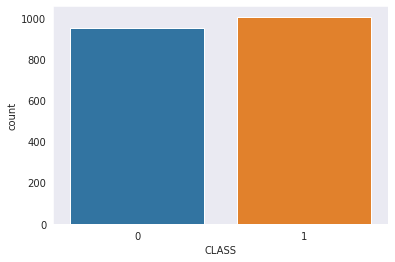

In [21]:
sns.set_style("dark")
sns.countplot(df.CLASS)

**See how our content look like**

In [62]:
  for i,content in enumerate (df['CONTENT'], 1):
    if i > 40:
        break
    else:
        print(i, content)



1 i love this so much. AND also I Generate Free Leads on Auto Pilot &amp; You Can  Too! http://www.MyLeaderGate.com/moretraffic﻿
2 http://www.billboard.com/articles/columns/pop-shop/6174122/fan-army-face-off-round-3 Vote for SONES please....we're against vips....please help us.. &gt;.&lt;﻿
3 Hey guys! Please join me in my fight to help abused/mistreated animals! All  fund will go to helping pay for vet bills/and or helping them find homes! I  will place an extra emphasis on helping disabled animals, ones otherwise  would just be put to sleep by other animal organizations. Donate please. http://www.gofundme.com/Angels-n-Wingz﻿
4 http://psnboss.com/?ref=2tGgp3pV6L this is the song﻿
5 Hey everyone. Watch this trailer!!!!!!!!  http://believemefilm.com?hlr=h2hQBUVB﻿
6 check out my rapping hope you guys like it  https://soundcloud.com/nereboy/call-of-the-lostproduce-by-atlastatlas-rapper-jkork  and follow and message me :)﻿
7 Subscribe pleaaaase to my instagram account , i'll subscribe back 

In [95]:
text="Hello everyone, my name is CHICKEN, my infomation https://www.youtube.com/watch?v=T0sHaz4H9MQ, kukir@gmail.com, 888.456.1478, 800 $ "
text=standardize_data(text)
print(remove_stopwords(text))


['Hello', 'everyone', 'name', 'CHICKEN', 'infomation', 'webaddress', 'email', 'phonenb', 'numbr', 'moneysb']


**Standardize data, remove punctuation, remove stopwords, tokenization**

In [137]:
def standardize_data(text):
  # Replace email addresses with 'email'
  re_email=re.compile('[\w\.-]+@[\w\.-]+(\.[\w]+)+')
  text=re.sub(re_email,'email',text)

  # Replace URLs with 'webaddress'
  re_url=re.compile('(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?')
  text=re.sub(re_url,'webaddress',text)

  # Replace money symbols with 'moneysymb'
  re_moneysb=re.compile('\$')
  text=re.sub(re_moneysb,'moneysb',text)

  # Remove ufeff 
  re_moneysb=re.compile('\ufeff|\\ufeff')
  text=re.sub(re_moneysb,' ',text)

  # Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
  re_phonenb=re.compile('(\d{3}[-\.\s]??\d{3}[-\.\s]??\d{4}|\(\d{3}\)\s*\d{3}[-\.\s]??\d{4}|\d{3}[-\.\s]??\d{4})')
  text=re.sub(re_phonenb,'phonenb',text)

  # Replace numbers with 'numbr'
  re_number=re.compile('\d+(\.\d+)?')
  text=re.sub(re_number,'numbr',text)

  # Remove puntuation
  text=text.translate(str.maketrans('', '', punctuation))

  # Replace whitespace between terms with a single space
  re_space=re.compile('\s+')
  text=re.sub(re_space,' ',text)

  # Remove leading and trailing whitespace
  re_space=re.compile('^\s+|\s+?$')
  text=re.sub(re_space,' ',text)

  return text


def remove_stopwords(text):
  stop_words = set(stopwords.words('english'))
  token=[term for term in text.split() if term not in stop_words]
  return token

hl_tokens = []

for hl in df['CONTENT']:
    hl=standardize_data(hl)
    hl=remove_stopwords(hl)
    hl_tokens.append(hl)
    
# View comparison
index=7
print('Original texts :')
print(df['CONTENT'][index])
print('\nAfter cleansed :')
print(hl_tokens[index])

Original texts :
hey guys!! visit my channel pleaase (i'm searching a dream)﻿

After cleansed :
['hey', 'guys', 'visit', 'channel', 'pleaase', 'im', 'searching', 'dream']


**Lemmatization**

In [0]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# Init Lemmatizer
lemmatizer = WordNetLemmatizer()

hl_lemmatized = []
for tokens in hl_tokens:
    lemm = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokens]
    hl_lemmatized.append(lemm)
    

In [139]:
# Example comparison
index=7
word_1 = hl_tokens[index]
word_2 = hl_lemmatized[index]
print('Before lemmatization\n',word_1)
print('\nAfter lemmatization\n',word_2)

Before lemmatization
 ['hey', 'guys', 'visit', 'channel', 'pleaase', 'im', 'searching', 'dream']

After lemmatization
 ['hey', 'guy', 'visit', 'channel', 'pleaase', 'im', 'search', 'dream']


Number of words: 4674
Most common words: [('I', 556), ('numbr', 389), ('video', 330), ('song', 287), ('Check', 248), ('check', 241), ('like', 214), ('webaddress', 164), ('love', 154), ('YouTube', 153), ('channel', 151), ('get', 143), ('make', 142), ('You', 134), ('subscribe', 133)]


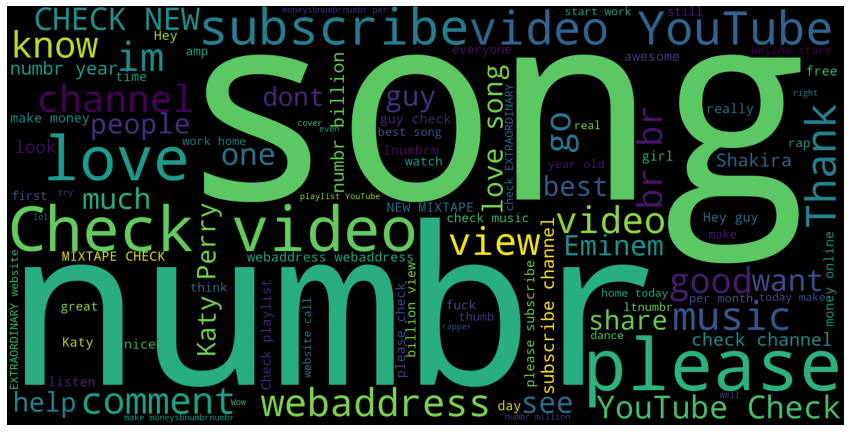

In [185]:
# create bag-of-words
all_words = []

for token in hl_lemmatized:
    for w in token:
          all_words.append(w)

corpus=' '.join(all_words)
all_words = nltk.FreqDist(all_words)

# print the total number of words and the 15 most common words
print('Number of words: {}'.format(len(all_words)))
print('Most common words: {}'.format(all_words.most_common(15)))


import wordcloud
import matplotlib.pyplot as plt
%matplotlib inline
#cloud = np.array(all_words).flatten()
plt.figure(figsize=(15,10))
word_cloud = wordcloud.WordCloud(max_words=100,background_color ="black",
                               width=2000,height=1000,mode="RGB").generate(corpus)
plt.axis("off")
plt.imshow(word_cloud)

# ***Training LSTM Model***

In [0]:
# Vectorize and convert text into sequences
def vectorize_lstm(text):
  text=word_lenmatizer(text)
  sequences = tokenizer.texts_to_sequences(text)
  X = pad_sequences(sequences, maxlen=14)
  return X

max_features = 2000
max_token = len(max(hl_lemmatized,key=len))
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(hl_lemmatized)
sequences = tokenizer.texts_to_sequences(hl_lemmatized)
X = pad_sequences(sequences, maxlen=max_token)

In [194]:
print('Before vectorization & padding\n',hl_lemmatized[0])
print('\nAfter vectorization & padding\n',X[0])


Before vectorization & padding
 ['love', 'much', 'AND', 'also', 'I', 'Generate', 'Free', 'Leads', 'Auto', 'Pilot', 'amp', 'You', 'Can', 'Too', 'webaddress']

After vectorization & padding
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    9   49   50
  105    2  950   71 1442 1443 1444  113   12  124  505   13]
110


Split Train, Test

In [0]:
Y = df['CLASS'].values
Y = np.vstack(Y)
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3, random_state = 42)

In [0]:
clear_session()

Building the Model

In [212]:
embed_dim = 64
model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = max_token))
model.add(LSTM(96, dropout=0.2, recurrent_dropout=0.2, activation='relu'))
model.add(Dense(100))
model.add(BatchNormalization())
# model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 110, 64)           128000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 96)                61824     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               9700      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                

Training process

In [213]:
epoch = 40
batch_size = 128
history=model.fit(X_train, Y_train, epochs = epoch, batch_size=batch_size, verbose = 2, validation_split=0.2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1095 samples, validate on 274 samples
Epoch 1/40
 - 2s - loss: 0.6271 - accuracy: 0.6502 - val_loss: 0.6835 - val_accuracy: 0.6934
Epoch 2/40
 - 2s - loss: 0.4263 - accuracy: 0.8201 - val_loss: 0.6665 - val_accuracy: 0.6277
Epoch 3/40
 - 2s - loss: 0.2374 - accuracy: 0.9187 - val_loss: 0.6369 - val_accuracy: 0.6934
Epoch 4/40
 - 2s - loss: 0.1440 - accuracy: 0.9498 - val_loss: 0.6077 - val_accuracy: 0.7007
Epoch 5/40
 - 2s - loss: 0.0987 - accuracy: 0.9726 - val_loss: 0.6022 - val_accuracy: 0.6022
Epoch 6/40
 - 2s - loss: 0.0654 - accuracy: 0.9772 - val_loss: 0.5953 - val_accuracy: 0.5912
Epoch 7/40
 - 2s - loss: 0.0515 - accuracy: 0.9826 - val_loss: 0.5767 - val_accuracy: 0.6314
Epoch 8/40
 - 2s - loss: 0.0372 - accuracy: 0.9900 - val_loss: 0.5616 - val_accuracy: 0.6569
Epoch 9/40
 - 2s - loss: 0.0326 - accuracy: 0.9909 - val_loss: 0.5473 - val_accuracy: 0.6971
Epoch 10/40
 - 2s - loss: 0.0379 - accuracy: 0.9845 - val_loss: 0.5270 - val_accuracy: 0.7190
Epoch 11/40
 - 2s - lo

# ***Model Evaluation***



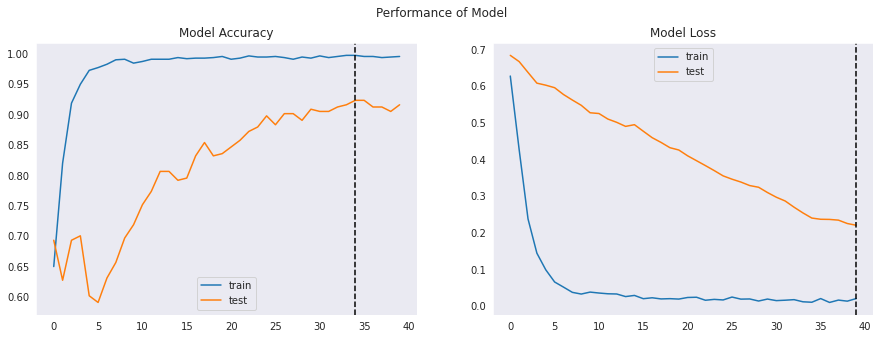

In [214]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
fig.suptitle("Performance of Model")
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
vline_cut = np.where(history.history['val_accuracy'] == np.max(history.history['val_accuracy']))[0][0]
ax1.axvline(x=vline_cut, color='k', linestyle='--')
ax1.set_title("Model Accuracy")
ax1.legend(['train', 'test'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
vline_cut = np.where(history.history['val_loss'] == np.min(history.history['val_loss']))[0][0]
ax2.axvline(x=vline_cut, color='k', linestyle='--')
ax2.set_title("Model Loss")
ax2.legend(['train', 'test'])
plt.show()

# ***Test Model***

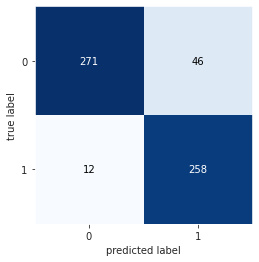

In [215]:
pred=np.around(model.predict(X_test))
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(Y_test,pred))
plt.show()

In [216]:
print(classification_report(Y_test,pred))

              precision    recall  f1-score   support

           0       0.96      0.85      0.90       317
           1       0.85      0.96      0.90       270

    accuracy                           0.90       587
   macro avg       0.90      0.91      0.90       587
weighted avg       0.91      0.90      0.90       587



# ***Use Another ML Algorithms to Classify***

**Preparing the Data**

In [0]:
X = [" ".join(x) for x in hl_lemmatized]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X,df['CLASS'],test_size=0.3)

**Word Vectorization using TF-IDF**

In [0]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(X)
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [219]:
print(Tfidf_vect.vocabulary_)

{'love': 1840, 'much': 2054, 'and': 133, 'also': 107, 'generate': 1210, 'free': 1148, 'leads': 1739, 'auto': 210, 'pilot': 2361, 'amp': 124, 'you': 3615, 'can': 425, 'too': 3200, 'webaddress': 3449, 'vote': 3381, 'sones': 2893, 'pleasewere': 2390, 'vipsplease': 3365, 'help': 1372, 'gtlt': 1295, 'hey': 1384, 'guy': 1309, 'please': 2387, 'join': 1634, 'fight': 1080, 'abusedmistreated': 14, 'animal': 140, 'all': 96, 'fund': 1179, 'go': 1237, 'pay': 2310, 'vet': 3336, 'billsand': 318, 'find': 1090, 'home': 1409, 'place': 2367, 'extra': 1006, 'emphasis': 920, 'disabled': 780, 'one': 2243, 'otherwise': 2267, 'would': 3559, 'put': 2491, 'sleep': 2854, 'organization': 2263, 'donate': 819, 'song': 2894, 'everyone': 974, 'watch': 3420, 'trailer': 3216, 'check': 489, 'rap': 2546, 'hope': 1419, 'like': 1766, 'follow': 1115, 'message': 1956, 'subscribe': 3013, 'pleaaaase': 2383, 'instagram': 1548, 'account': 23, 'ill': 1494, 'back': 240, 'visit': 3371, 'channel': 472, 'pleaase': 2384, 'im': 1502, '

## **Trainning on the SVM classifier**

In [220]:
SVM = svm.SVC(C=1.0, kernel='linear', verbose=True)
SVM.fit(Train_X_Tfidf,Train_Y)

[LibSVM]

SVC(kernel='linear', verbose=True)

**Predict and evaluate the SVM classifier**

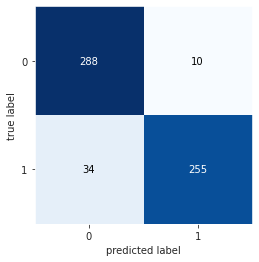

In [221]:
predictions_SVM=SVM.predict(Test_X_Tfidf)
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(Test_Y,predictions_SVM))
plt.show()

In [222]:
print(classification_report(Test_Y,predictions_SVM))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       298
           1       0.96      0.88      0.92       289

    accuracy                           0.93       587
   macro avg       0.93      0.92      0.92       587
weighted avg       0.93      0.93      0.92       587



## **Trainning on the Naive Bayes Classifier**

In [223]:
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)

MultinomialNB()

**Predict and evaluate the Naive Bayes Classifier**

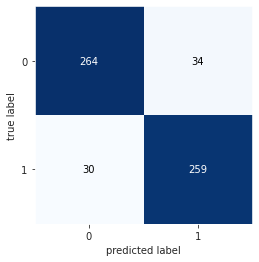

In [224]:
predictions_NB=Naive.predict(Test_X_Tfidf)
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(Test_Y,predictions_NB))
plt.show()

In [225]:
print(classification_report(Test_Y,predictions_NB))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89       298
           1       0.88      0.90      0.89       289

    accuracy                           0.89       587
   macro avg       0.89      0.89      0.89       587
weighted avg       0.89      0.89      0.89       587



# ***Save model***

In [226]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [233]:
joblib.dump(Tfidf_vect, '/content/drive/My Drive/model/tfidf.pkl')
joblib.dump(tokenizer, '/content/drive/My Drive/model/tokenizer_LSTM.pkl')
joblib.dump(model, '/content/drive/My Drive/model/LSTM_model.pkl')
joblib.dump(SVM, '/content/drive/My Drive/model/SVM_model.pkl')
joblib.dump(Naive, '/content/drive/My Drive/model/NB_model.pkl')
joblib.dump(Tfidf_vect.vocabulary_,'/content/drive/My Drive/model/vocalbulary.pkl' )

['/content/drive/My Drive/model/vocalbulary.pkl']

# ***Enter comment and check***

## *utils*

In [0]:
!ln -s /content/drive/'My Drive'/model

In [272]:
from nltk.corpus import wordnet,stopwords
from nltk.stem import WordNetLemmatizer
import re
import string
from string import digits, punctuation


def standardize_data(text):
  # Replace email addresses with 'email'
  re_email=re.compile('[\w\.-]+@[\w\.-]+(\.[\w]+)+')
  text=re.sub(re_email,'email',text)

  # Replace URLs with 'webaddress'
  re_url=re.compile('(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?')
  text=re.sub(re_url,'webaddress',text)

  # Replace money symbols with 'moneysymb'
  re_moneysb=re.compile('\$')
  text=re.sub(re_moneysb,'moneysb',text)

  # Remove ufeff 
  re_moneysb=re.compile('\ufeff|\\ufeff')
  text=re.sub(re_moneysb,' ',text)

  # Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
  re_phonenb=re.compile('(\d{3}[-\.\s]??\d{3}[-\.\s]??\d{4}|\(\d{3}\)\s*\d{3}[-\.\s]??\d{4}|\d{3}[-\.\s]??\d{4})')
  text=re.sub(re_phonenb,'phonenb',text)

  # Replace numbers with 'numbr'
  re_number=re.compile('\d+(\.\d+)?')
  text=re.sub(re_number,' numbr ',text)

  # Remove puntuation
  text=text.translate(str.maketrans('', '', punctuation))

  # Replace whitespace between terms with a single space
  re_space=re.compile('\s+')
  text=re.sub(re_space,' ',text)

  # Remove leading and trailing whitespace
  re_space=re.compile('^\s+|\s+?$')
  text=re.sub(re_space,' ',text)

  return text


def remove_stopwords(text):
  stop_words = set(stopwords.words('english'))
  token=[term for term in text.split() if term not in stop_words]
  return token

def word_lenmatizer(token):
    # Init Lemmatizer
    lemmatizer = WordNetLemmatizer()
    hl_lemmatized = []
    lemm = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in token]
    hl_lemmatized.append(lemm)
    return hl_lemmatized

def vectorize_lstm(w_lenmatizer,tokenizer):
  sequences = tokenizer.texts_to_sequences(w_lenmatizer)
  X = pad_sequences(sequences, maxlen=110)
  return X


def vectorize_clasifer(w_lenmatizer, tfidf_vector):
  w_lenmatizer = [" ".join(x) for x in w_lenmatizer]
  return tfidf_vector.transform(w_lenmatizer)


def LSTM_predict(text,model,tokenizer):
  print(text)
  text=standardize_data(text)
  token=remove_stopwords(text)
  w_lenmatizer=word_lenmatizer(token)
  max_token = 110
  sequences = tokenizer.texts_to_sequences(w_lenmatizer)
  X = pad_sequences(sequences, maxlen=max_token)
  if np.around(model.predict(X)[0])==1:
    print("=============> SPAM\n")
  else:
    print("=============> HAM\n")

def predict(text,model,tfidf_vector):
  print(text)
  text=standardize_data(text)
  token=remove_stopwords(text)
  w_lenmatizer=word_lenmatizer(token)
  w_lenmatizer = [" ".join(x) for x in w_lenmatizer]
  X_Tfidf = tfidf_vector.transform(w_lenmatizer)
  if model.predict(X_Tfidf)[0]==1:
    print("=============> SPAM\n")
  else:
    print("=============> HAM\n")



model_LSTM=joblib.load('/content/model/LSTM_model.pkl')
tokenizer_LSTM=joblib.load('/content/model/tokenizer_LSTM.pkl')
SVM_model=joblib.load('/content/model/SVM_model.pkl')
NB_model=joblib.load('/content/model/NB_model.pkl')
tfidf_vec=joblib.load('/content/model/tfidf.pkl')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


## Explaining function

* **Step 1**: Standardize text, remove punctuation, replace url = 'webaddrress', replace email= 'email', replace phone_number = 'phonenb', replace money_sign = 'moneysb'*

In [274]:
text="hey guys!! visit my channel pleaase (i'm searching a dream), https://www.youtube.com/watch?, nanidefuck@gmail.com, 888.888.8888, 100.000$"

clean=standardize_data(text)
print('Raw: ', text)
print('\nResult: ',clean)

Raw:  hey guys!! visit my channel pleaase (i'm searching a dream), https://www.youtube.com/watch?, nanidefuck@gmail.com, 888.888.8888, 100.000$

Result:  hey guys visit my channel pleaase im searching a dream webaddress email phonenb numbr moneysb


* **Step 2**: Remove stopwords and tokenization *

In [275]:
token=text=remove_stopwords(clean)

print('text: ', clean)
print('\nResult: ',token)

text:  hey guys visit my channel pleaase im searching a dream webaddress email phonenb numbr moneysb

Result:  ['hey', 'guys', 'visit', 'channel', 'pleaase', 'im', 'searching', 'dream', 'webaddress', 'email', 'phonenb', 'numbr', 'moneysb']


* **Step 3**: Lemmatizer *


In [276]:
w_lenmatizer=word_lenmatizer(token)

print('token: ', token)
print('\nResult: ',w_lenmatizer)

token:  ['hey', 'guys', 'visit', 'channel', 'pleaase', 'im', 'searching', 'dream', 'webaddress', 'email', 'phonenb', 'numbr', 'moneysb']

Result:  [['hey', 'guy', 'visit', 'channel', 'pleaase', 'im', 'search', 'dream', 'webaddress', 'email', 'phonenb', 'numbr', 'moneysb']]


* **Step 4**: Vectorization & padding *



In [278]:
print('Input for LSTM model: ', vectorize_lstm(w_lenmatizer,tokenizer_LSTM))

Input for LSTM model:  [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
    30   19   62   11 1457   27  303  106   13  828  841    3]]


In [281]:
print('Input vectorization by TF-IDF:\n', vectorize_clasifer(w_lenmatizer,tfidf_vec))

Input vectorization by TF-IDF:
   (0, 3449)	0.1983748007841132
  (0, 3371)	0.25134802704830456
  (0, 2730)	0.33709969161329356
  (0, 2384)	0.4300692279151255
  (0, 2347)	0.3922679995348285
  (0, 2156)	0.15809858092040308
  (0, 1502)	0.23388748451122798
  (0, 1384)	0.2249497546706754
  (0, 1309)	0.21406372808074012
  (0, 908)	0.3922679995348285
  (0, 835)	0.28423280723146277
  (0, 472)	0.18497302694298665


## Predict

Using LSTM model to predict

In [283]:
cmt='Please subcribe my channel https://www.youtube.com/watch?v=UZ0Dv9sGYvU&list=RDUZ0Dv9sGYvU&start_radio=1'
LSTM_predict(cmt,model_LSTM,tokenizer_LSTM)


cmt2='I just remembered the song because of Alvin and The Chipmunks 😂'
LSTM_predict(cmt2,model_LSTM,tokenizer_LSTM)

Please subcribe my channel https://www.youtube.com/watch?v=UZ0Dv9sGYvU&list=RDUZ0Dv9sGYvU&start_radio=1
=============> SPAM

I just remembered the song because of Alvin and The Chipmunks 😂
=============> HAM



Using SVM clasifier

In [284]:
cmt='Follow me on instagram, remember to like and subcribe'
predict(cmt,SVM_model,tfidf_vec)


cmt2='This is probably the best song that represents the world cup ever.'
predict(cmt2,SVM_model,tfidf_vec)

Follow me on instagram, remember to like and subcribe
=============> SPAM

This is probably the best song that represents the world cup ever.
=============> HAM



Using NB clasifier


In [285]:
cmt='Such a shame that this song didnt reach 1B in 10 years.'
predict(cmt,NB_model,tfidf_vec)


cmt2='LIKE THIS COMMENT IF YOU ARE WATCHING.'
predict(cmt2,NB_model,tfidf_vec)

Such a shame that this song didnt reach 1B in 10 years.
=============> HAM

LIKE THIS COMMENT IF YOU ARE WATCHING.
=============> SPAM

